In [1]:
import imagej
import matplotlib.pyplot as plt

ij = imagej.init(add_legacy=False)
print(f"ImageJ2 version: {ij.getVersion()}")

ImageJ2 version: 2.15.0


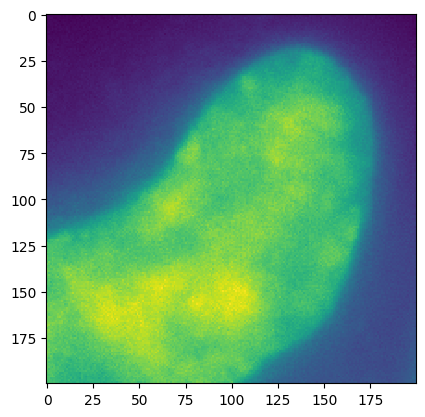

In [2]:
# open the 3D HeLa dataset
img = ij.io().open('https://media.imagej.net/workshops/data/3d/hela_nucleus.tif')

# display slice 30 of the dataset
ij.py.show(img[:, :, 30])

The input image is the original image img. The point spread function (PSF) can be either real (i.e. a collected PSF) or synthetic. This notebook will create a synthetic PSF using imagej-ops. iterations is the number of times the data is deconvolved (note: higher iteration values may introduce processing artifacts). The regularization factor reduces the noise amplified by the RL algorithm. Higer values result in greater noise suppression. For now lets set the number of iterations to 15 and the regularization factor to 0.002 (this value is derived from the Dey et. al paper).

In [3]:
# set the iterations and regularization factor for Richardson-Lucy TV
iterations = 15
reg = 0.002

In [4]:
na = 1.45 # numerical aperture
wv = 457 # emission wavelength
ri_immersion = 1.5 # refractive index (immersion)
ri_sample = 1.4 # refractive index (sample)
lat_res = 0.065 # lateral resolution (i.e. xy)
ax_res = 0.1 # axial resolution (i.e. z)
pz = 0 # distance away from coverslip

In [5]:
# import imagej2 and imglib2 Java classes
CreateNamespace = imagej.sj.jimport('net.imagej.ops.create.CreateNamespace')
FinalDimensions = imagej.sj.jimport('net.imglib2.FinalDimensions')
FloatType = imagej.sj.jimport('net.imglib2.type.numeric.real.FloatType')

In [6]:
# convert input parameters into meters
wv = wv * 1E-9
lat_res = lat_res * 1E-6
ax_res = ax_res * 1E-6
pz = pz * 1E-6

In [7]:
# convert the input image dimensions to imglib2 FinalDimensions
psf_dims = FinalDimensions(img.shape)

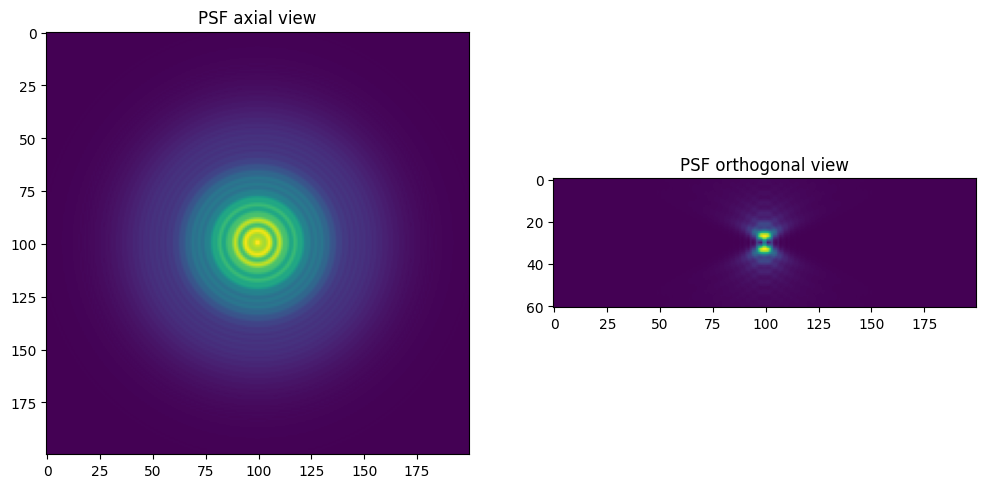

In [8]:
# create synthetic PSF
psf = ij.op().namespace(CreateNamespace).kernelDiffraction(psf_dims, na, wv, ri_sample, ri_immersion, lat_res, ax_res, pz, FloatType())

# convert PSF from Java to Python (numpy array)
psf_narr = ij.py.from_java(psf)

# display the axial and orthogonal side view of the PSF side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 9))
ax[0].imshow(psf_narr[5, :, :])
ax[0].set_title("PSF axial view")

# transpose the array to create an orthogonal side view
xz_psf_narr = psf_narr.transpose(1, 0, 2)
ax[1].imshow(xz_psf_narr[102, :, :])
ax[1].set_title("PSF orthogonal view")

# display plot
plt.show()

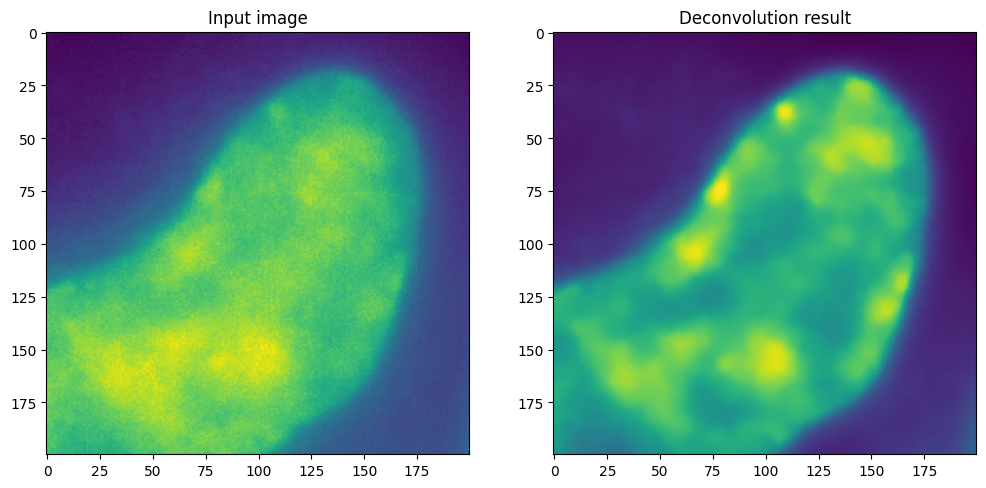

In [9]:
# convert input image to 32-bit and deconvolve with RLTV
img_f = ij.op().convert().float32(img)
img_decon = ij.op().deconvolve().richardsonLucyTV(img_f, psf, iterations, reg)

# display slice 30 of the input image and deconvolution result side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 9))
ax[0].imshow(ij.py.from_java(img[:, :, 30]))
ax[0].set_title("Input image")
ax[1].imshow(ij.py.from_java(img_decon[:, :, 30]))
ax[1].set_title("Deconvolution result")

# display plot
plt.show()